# Get Data

In [2]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath

import wfdb

## Extracting signal from .dat files

### The signal was extracted and turned into a numpy array and then plotted using the time in seconds as the x-axis

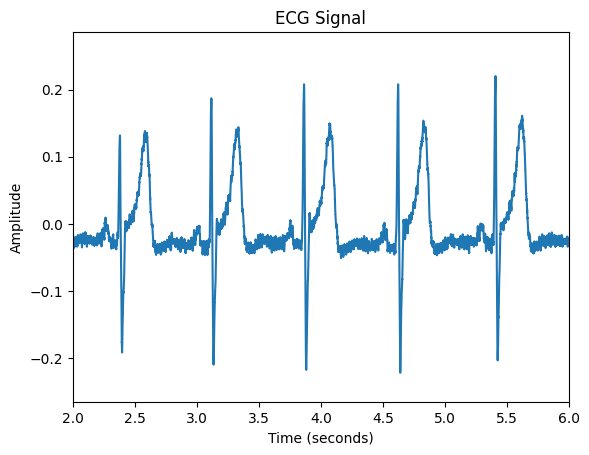

In [3]:

# Load the record using wfdb.rdrecord
record = wfdb.rdrecord('Data/Resting/ECGPCG0005')

# Extract the ECG signal from the record
ecg_signal = record.p_signal[:, 0]  # Assuming ECG signal is in the first channel (0-indexed)


# Convert the ECG segment to a NumPy array
ecg_array = np.array(ecg_signal)

# Get the sampling rate
sampling_rate = record.fs

# Calculate the corresponding time axis
time = np.arange(0, len(ecg_array)) / sampling_rate

# Plot the ECG signal against time
plt.plot(time, ecg_array)

# Add labels and title to the plot
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal')

# Set the limits for the zoomed-in region
zoom_start_time = 2  # Replace with the desired start time of the zoomed-in region
zoom_end_time = 6 # Replace with the desired end time of the zoomed-in region

# Adjust the limits of the x-axis and y-axis
plt.xlim(zoom_start_time, zoom_end_time)

# Display the plot
plt.show()

## The fourier transform of the signal is taken to show the spectral plot, therefore highlighting the most significant frequencies

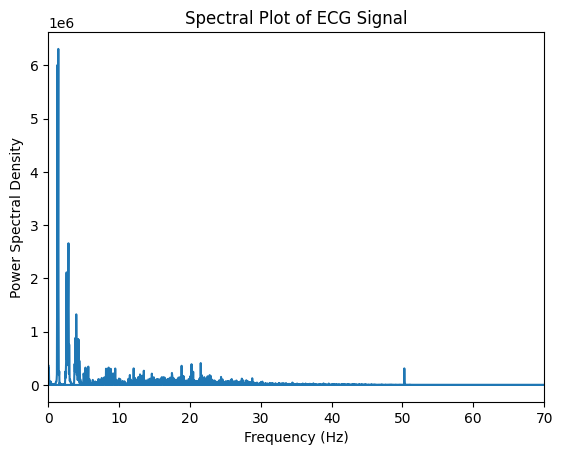

In [4]:
# Perform the Fourier transform
fourier_transform = np.fft.fft(ecg_array)

# Calculate the power spectral density (PSD)
power_spectrum = np.abs(fourier_transform) ** 2

# Get the sampling rate
sampling_rate = record.fs

# Create the frequency axis
frequency_bins = np.fft.fftfreq(len(ecg_array), d=1/sampling_rate)

# Plot the PSD
plt.plot(frequency_bins, power_spectrum)

# Set the x-axis limits to display positive frequencies only
plt.xlim(0, sampling_rate / 2)

# Add labels and title to the plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Spectral Plot of ECG Signal')

# Set the limits for the zoomed-in region
zoom_start_freq = 0  # Replace with the desired start frequency of the zoomed-in region
zoom_end_freq = 70  # Replace with the desired end frequency of the zoomed-in region

# Adjust the limits of the x-axis and/or y-axis for zooming in
plt.xlim(zoom_start_freq, zoom_end_freq)

# Display the plot
plt.show()

## Now the y-axis is changed to percentage affecting the amplitude vs. the frequency

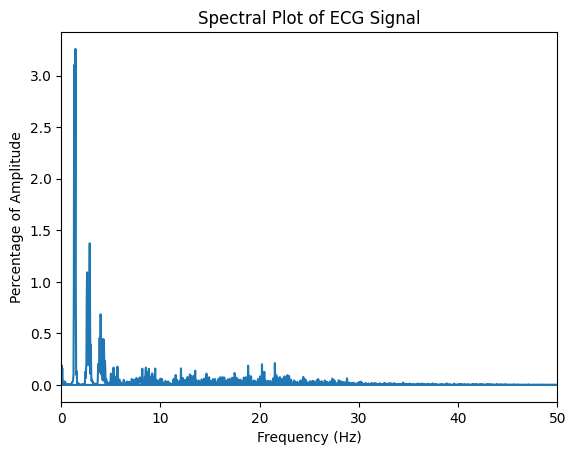

In [5]:
# Normalize the power spectrum to sum up to 100
normalized_spectrum = (power_spectrum / np.sum(power_spectrum)) * 100

# Plot the spectral plot with the y-axis as a percentage
plt.plot(frequency_bins, normalized_spectrum)

# Set the limits for the zoomed-in region
zoom_start_freq = 0  # Replace with the desired start frequency of the zoomed-in region
zoom_end_freq = 50# Replace with the desired end frequency of the zoomed-in region

# Adjust the limits of the x-axis for zooming in
plt.xlim(zoom_start_freq, zoom_end_freq)

# Add labels and title to the plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Percentage of Amplitude')
plt.title('Spectral Plot of ECG Signal')

# Display the plot
plt.show()

## Now a loop will be performed to find the average percentage of amplitude for the file that are present in total

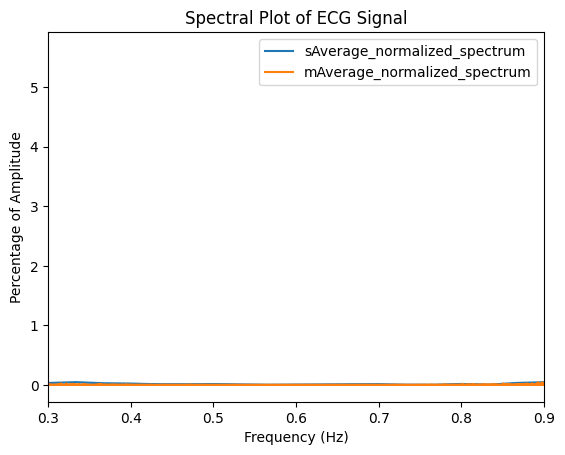

In [6]:
sfileEndings = ['03','04','05','06','07','08','09']
mfileEndings = ['10','11','13','15','16']
sAverage_frequency_bins = None
sAverage_normalized_spectrum = None
mAverage_frequency_bins = None
mAverage_normalized_spectrum = None
for f in sfileEndings:
    record = wfdb.rdrecord('Data/Resting/ECGPCG00'+f)
    ecg_signal = record.p_signal[:, 0]  # Assuming ECG signal is in the first channel (0-indexed)
    ecg_array = np.array(ecg_signal)
    sampling_rate = record.fs
    time = np.arange(0, len(ecg_array)) / sampling_rate
    fourier_transform = np.fft.fft(ecg_array)
    power_spectrum = np.abs(fourier_transform) ** 2
    sampling_rate = record.fs
    frequency_bins = np.fft.fftfreq(len(ecg_array), d=1/sampling_rate)
    if sAverage_frequency_bins is None:
        sAverage_frequency_bins = frequency_bins
    normalized_spectrum = (power_spectrum / np.sum(power_spectrum)) * 100
    if sAverage_normalized_spectrum is None:
        sAverage_normalized_spectrum = normalized_spectrum
    else:
        sAverage_normalized_spectrum += normalized_spectrum
sAverage_normalized_spectrum /= len(sfileEndings)

for f in mfileEndings:
    record = wfdb.rdrecord('Data/Resting/ECGPCG00'+f)
    ecg_signal = record.p_signal[:, 0]  # Assuming ECG signal is in the first channel (0-indexed)
    ecg_array = np.array(ecg_signal)
    sampling_rate = record.fs
    time = np.arange(0, len(ecg_array)) / sampling_rate
    fourier_transform = np.fft.fft(ecg_array)
    power_spectrum = np.abs(fourier_transform) ** 2
    sampling_rate = record.fs
    frequency_bins = np.fft.fftfreq(len(ecg_array), d=1/sampling_rate)
    if mAverage_frequency_bins is None:
        mAverage_frequency_bins = frequency_bins
    normalized_spectrum = (power_spectrum / np.sum(power_spectrum)) * 100
    if mAverage_normalized_spectrum is None:
        mAverage_normalized_spectrum = normalized_spectrum
    else:
        mAverage_normalized_spectrum += normalized_spectrum
mAverage_normalized_spectrum /= len(mfileEndings)
mAverage_normalized_spectrum *= 10





# Plot sAverage_normalized_spectrum
plt.plot(sAverage_frequency_bins, sAverage_normalized_spectrum, label='sAverage_normalized_spectrum')

# Plot mAverage_normalized_spectrum
plt.plot(mAverage_frequency_bins, mAverage_normalized_spectrum, label='mAverage_normalized_spectrum')

# Set the limits for the zoomed-in region
zoom_start_freq = 0.3  # Replace with the desired start frequency of the zoomed-in region
zoom_end_freq = 0.9 # Replace with the desired end frequency of the zoomed-in region

# Adjust the limits of the x-axis for zooming in
plt.xlim(zoom_start_freq, zoom_end_freq)

# Add labels and title to the plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Percentage of Amplitude')
plt.title('Spectral Plot of ECG Signal')

# Show the legend
plt.legend()

# Display the plot
plt.show()

### After seeing the average spectrums on the data it is noticed that the most important frequencies in the normal non-noisy ECGs are between 0-0.1 Hz and 1-25 Hz, so a filter will be needed to remove any other frequencies in a random ECG

## Now a noisy signal will be taken and plotted

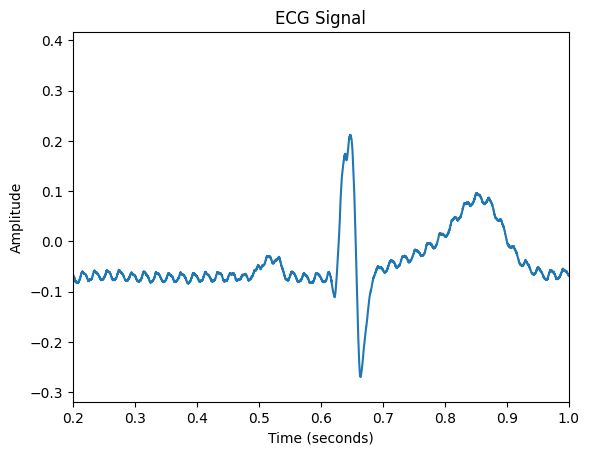

In [69]:
# Load the record using wfdb.rdrecord
record = wfdb.rdrecord('Data/Resting/ECGPCG0004')

# Extract the ECG signal from the record
ecg_signal = record.p_signal[:, 0]  # Assuming ECG signal is in the first channel (0-indexed)


# Convert the ECG segment to a NumPy array
ecg_array = np.array(ecg_signal)

# Get the sampling rate
sampling_rate = record.fs

# Calculate the corresponding time axis
time = np.arange(0, len(ecg_array)) / sampling_rate

# Plot the ECG signal against time
plt.plot(time, ecg_array)

# Add labels and title to the plot
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal')

# Set the limits for the zoomed-in region
zoom_start_time = 0.2  # Replace with the desired start time of the zoomed-in region
zoom_end_time = 1 # Replace with the desired end time of the zoomed-in region

# Adjust the limits of the x-axis and y-axis
plt.xlim(zoom_start_time, zoom_end_time)

# Display the plot
plt.show()

## Now the frequency spectrum will be plotted

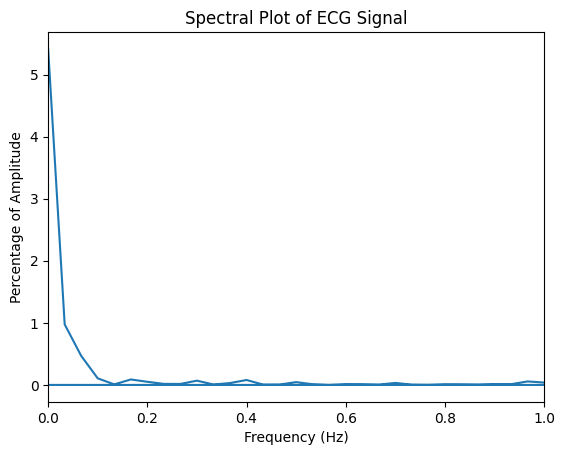

In [58]:

# Perform the Fourier transform
fourier_transform = np.fft.fft(ecg_array)

# Calculate the power spectral density (PSD)
power_spectrum = np.abs(fourier_transform) ** 2

# Get the sampling rate
sampling_rate = record.fs

# Create the frequency axis
frequency_bins = np.fft.fftfreq(len(ecg_array), d=1/sampling_rate)

# Normalize the power spectrum to sum up to 100
normalized_spectrum = (power_spectrum / np.sum(power_spectrum)) * 100

# Plot the spectral plot with the y-axis as a percentage
plt.plot(frequency_bins, normalized_spectrum)

# Set the limits for the zoomed-in region
zoom_start_freq = 0  # Replace with the desired start frequency of the zoomed-in region
zoom_end_freq = 1# Replace with the desired end frequency of the zoomed-in region

# Adjust the limits of the x-axis for zooming in
plt.xlim(zoom_start_freq, zoom_end_freq)

# Add labels and title to the plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Percentage of Amplitude')
plt.title('Spectral Plot of ECG Signal')

# Display the plot
plt.show()

## Since 50 Hz frequency percentage amplitude is large compared to the other frequencies, it is most likely power line noise since its usually 50 Hz or 60 Hz based on the location

## The signal will now be filtered, using the appropriate Low-pass and Band-reject filters, and then plotted

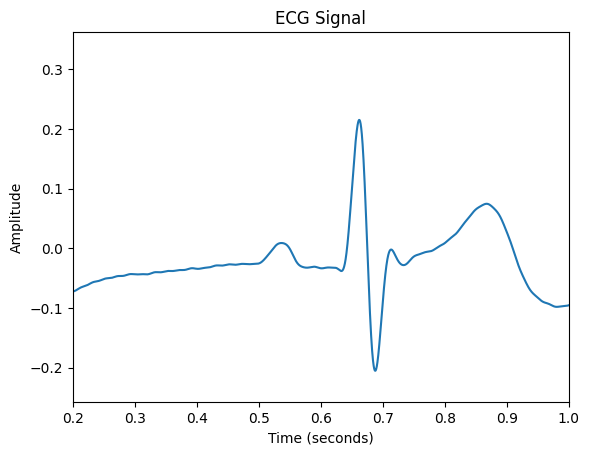

In [65]:
from scipy import signal

# Sample rate (in Hz) and duration of the signal
fs = sampling_rate
duration = time

# Create a low-pass filter
cutoff_freq = 25  # Cutoff frequency (in Hz)
nyquist_freq = 0.5 * fs
normalized_cutoff = cutoff_freq / nyquist_freq
b, a = signal.butter(4, normalized_cutoff, 'lowpass')  # 4th order Butterworth filter

# Apply the low-pass filter to the noisy signal
filtered_signal = signal.lfilter(b, a, ecg_array)


# Create a bandreject filter
band_freq = [0.43, 0.77]  # Frequency range to reject (in Hz)
nyquist_freq = 0.5 * fs
normalized_band = [freq / nyquist_freq for freq in band_freq]

# Design the filter
order = 2  # Filter order
b, a = signal.butter(order, normalized_band, btype='bandstop')

# Apply the filter to the lowpass filtered signal
filtered_signal = signal.lfilter(b, a, filtered_signal)

# Calculate the corresponding time axis
time = np.arange(0, len(filtered_signal)) / sampling_rate

# Plot the ECG signal against time
plt.plot(time, filtered_signal)

# Add labels and title to the plot
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal')

# Set the limits for the zoomed-in region
zoom_start_time = 0.2 # Replace with the desired start time of the zoomed-in region
zoom_end_time = 1 # Replace with the desired end time of the zoomed-in region

# Adjust the limits of the x-axis and y-axis
plt.xlim(zoom_start_time, zoom_end_time)

# Display the plot
plt.show()

## Now the frequency spectrum will be plotted

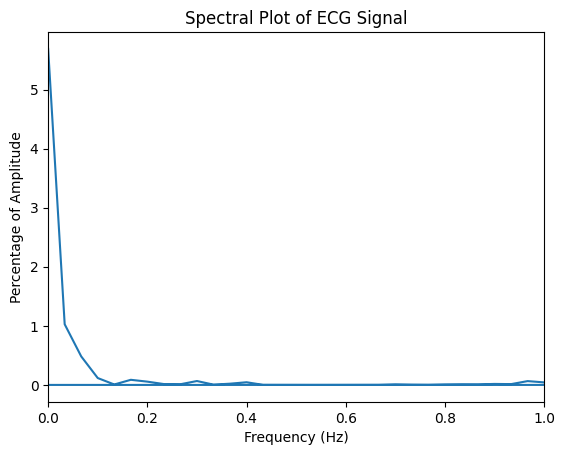

In [66]:

# Perform the Fourier transform
fourier_transform = np.fft.fft(filtered_signal)

# Calculate the power spectral density (PSD)
power_spectrum = np.abs(fourier_transform) ** 2

# Get the sampling rate
sampling_rate = record.fs

# Create the frequency axis
frequency_bins = np.fft.fftfreq(len(filtered_signal), d=1/sampling_rate)

# Normalize the power spectrum to sum up to 100
normalized_spectrum = (power_spectrum / np.sum(power_spectrum)) * 100

# Plot the spectral plot with the y-axis as a percentage
plt.plot(frequency_bins, normalized_spectrum)

# Set the limits for the zoomed-in region
zoom_start_freq = 0  # Replace with the desired start frequency of the zoomed-in region
zoom_end_freq =1# Replace with the desired end frequency of the zoomed-in region

# Adjust the limits of the x-axis for zooming in
plt.xlim(zoom_start_freq, zoom_end_freq)

# Add labels and title to the plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Percentage of Amplitude')
plt.title('Spectral Plot of ECG Signal')

# Display the plot
plt.show()

### Now the RMS of the signal will be taken

/var/folders/n5/9hwnvt3941b4lw84xm2k6wjr0000gn/T/ipykernel_13564/102207427.py:4: RuntimeWarning: divide by zero encountered in divide
  rms = np.sqrt(cumulative_integral / time)


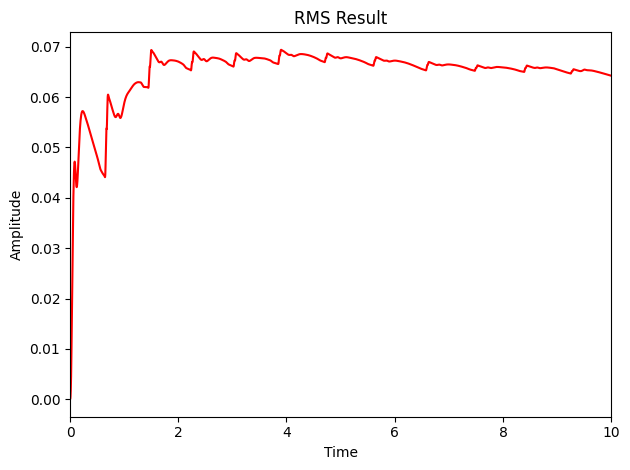

In [90]:
def calculate_rms(signal, time):
    squared_signal = np.square(signal)
    cumulative_integral = np.cumsum(squared_signal) * (time[1] - time[0])
    rms = np.sqrt(cumulative_integral / time)
    return rms


rms = calculate_rms(filtered_signal,time)

# Set the limits for the zoomed-in region
zoom_start_freq = 0  # Replace with the desired start frequency of the zoomed-in region
zoom_end_freq = 10# Replace with the desired end frequency of the zoomed-in region

# Adjust the limits of the x-axis for zooming in
plt.xlim(zoom_start_freq, zoom_end_freq)

plt.plot(time, rms, 'r')
plt.title('RMS Result')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

### Now the Teager Operator will be applied to the signal to better show the peaks

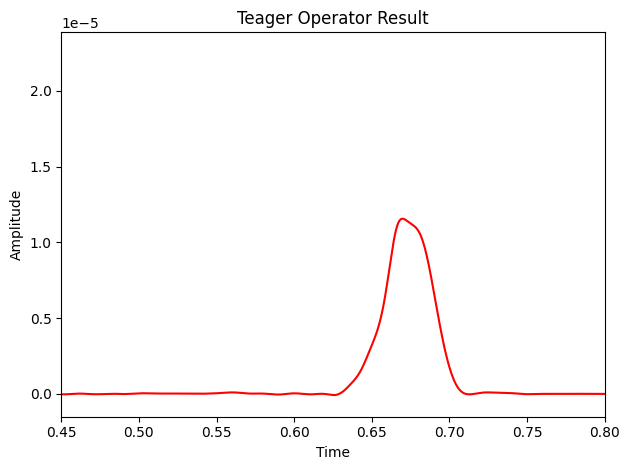

In [91]:
def teager_operator(signal):
    squared_signal = np.square(signal)
    teager_signal = squared_signal[1:-1] - signal[:-2] * signal[2:]
    return teager_signal


# Apply the Teager operator
teager_signal = teager_operator(filtered_signal)
# Set the limits for the zoomed-in region
zoom_start_freq = 0.45  # Replace with the desired start frequency of the zoomed-in region
zoom_end_freq =0.8# Replace with the desired end frequency of the zoomed-in region

# Adjust the limits of the x-axis for zooming in
plt.xlim(zoom_start_freq, zoom_end_freq)

plt.plot(time[1:-1], teager_signal, 'r')
plt.title('Teager Operator Result')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()